In [1]:
import cv2
import mediapipe as mp
import math
import pandas as pd
import numpy as np

In [2]:
mpHands = mp.solutions.hands
hands = mpHands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7,
    max_num_hands=1
)

I0000 00:00:1764206440.052894 2493410 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
def scaleLandmarks(landmarks):
    scale = abs(landmarks[5][0] - landmarks[0][0]) * 2
    originX = landmarks[0][0]
    originY = landmarks[0][1]

    scaledLandmarks = []
    for i in landmarks:
        scaledX = (i[0] - originX) / scale
        scaledY = (i[1] - originY) / scale
        scaledLandmarks.append([scaledX, scaledY])
    return scaledLandmarks

# Rotates a point based on the origin and how many radians to rotate.
# Returns an array of integers for the new rotated point.
def rotate(origin, point, angle):
    ox = origin[0]
    oy = origin[1]
    px = point[0]
    py = point[1]

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return [int(qx), int(qy)] 

# Returns landmarks of the hand normalized with position of fingers between 0 and 1.
def normalizeHand(frame, landmarks):
    imgHeight = frame.shape[0]
    imgWidth = frame.shape[1]

    # Convert the relative position to the X, Y coordinates of the landmarks (Which are between 0 and 1) to the absolute coordinates with the image resolution.
    realLandmarks = []
    for i in landmarks:
      x = i[0]
      y = i[1]
      realLandmarks.append([int(imgWidth * x), int(imgHeight * y)])

    # Get angle of main landmarks (Base of hand and center of hand.)
    rotatedHand = []
    diffY = realLandmarks[5][1] - realLandmarks[0][1]
    diffX = realLandmarks[5][0] - realLandmarks[0][0]
    angle = math.atan2(diffY, diffX)
    for i in range(21):
      # Exclude rotating the center itself.
      rotatedLandmark = rotate(realLandmarks[5], realLandmarks[i], -angle)
      rotatedHand.append(rotatedLandmark) 

    for i in rotatedHand:
      cv2.circle(frame, (i[0], i[1]), radius=10, color=(0,0,255), thickness=10)
    scaledLandmarks = scaleLandmarks(rotatedHand)
    return scaledLandmarks

def createRow(landmarks, label):
    data = {}
    
    for i in range(len(landmarks)):
        data[f"x{i}"] = landmarks[i][0]
        data[f"y{i}"] = landmarks[i][1]
    data['label'] = label
    df = pd.DataFrame(data, index=[0])
    return df

def exportData(data: pd.DataFrame):
    print('Export')
    print(data.shape)
    print(data)
    data.to_csv('train.csv', index=False)


W0000 00:00:1764206440.057750 2493504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764206440.060937 2493504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [ ]:
waitFrame = 0
draw = mp.solutions.drawing_utils
cap = cv2.VideoCapture(0)

print("How many classes do you want?")
inputClasses = int(input("Number of classes: "))

print("How many samples do you want per class?")
inputTarget = int(input("Target of Images: "))
dfExportData = pd.DataFrame({})
currentClass = 0
currentCapture = 0


try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)
        frameRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        processed = hands.process(frameRGB)

        landmark_list = []
        if processed.multi_hand_landmarks:
            hand_landmarks = processed.multi_hand_landmarks[0]  # Assuming only one hand is detected
            draw.draw_landmarks(frame, hand_landmarks, mpHands.HAND_CONNECTIONS)
            for lm in hand_landmarks.landmark:
                landmark_list.append((lm.x, lm.y))
        waitFrame += 1
        if len(landmark_list) == 21:
            # MARK: Here you can add code or functions to detect the gestures
            # Here i am detecting a hand and rotating it to keep it constant.
            if waitFrame > 0:
                waitFrame = 0
                capturedLandmarks = normalizeHand(frame, landmark_list)
                classOffset = currentClass + 5
                newData = createRow(capturedLandmarks, classOffset)
                dfExportData = pd.concat([dfExportData, newData], ignore_index=True)
                currentCapture += 1

            if currentCapture == inputTarget and currentClass < inputClasses:
                _ = input("Prepare for capture the next class")
                currentCapture = 0
                currentClass += 1
            if currentClass == inputClasses:
                exportData(dfExportData)
                break
        
        cv2.imshow('Frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    cap.release()
    cv2.destroyAllWindows()

How many classes do you want?
How many samples do you want per class?


W0000 00:00:1764206447.754652 2493511 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Export
(30000, 43)
        x0   y0        x1        y1        x2        y2        x3        y3  \
0      0.0  0.0  0.211268  0.138498  0.453052  0.161972  0.671362  0.159624   
1      0.0  0.0  0.195833  0.125000  0.437500  0.137500  0.639583  0.139583   
2      0.0  0.0  0.197581  0.131048  0.427419  0.141129  0.629032  0.147177   
3      0.0  0.0  0.190840  0.124046  0.406489  0.137405  0.595420  0.141221   
4      0.0  0.0  0.196691  0.126838  0.398897  0.136029  0.579044  0.139706   
...    ...  ...       ...       ...       ...       ...       ...       ...   
29995  0.0  0.0  0.154255 -0.127660  0.347518 -0.195035  0.487589 -0.246454   
29996  0.0  0.0  0.155052 -0.123693  0.344948 -0.191638  0.484321 -0.245645   
29997  0.0  0.0  0.153448 -0.124138  0.343103 -0.191379  0.482759 -0.243103   
29998  0.0  0.0  0.155290 -0.122867  0.343003 -0.192833  0.486348 -0.249147   
29999  0.0  0.0  0.155116 -0.118812  0.339934 -0.189769  0.481848 -0.239274   

             x4        y4  ...  

: 

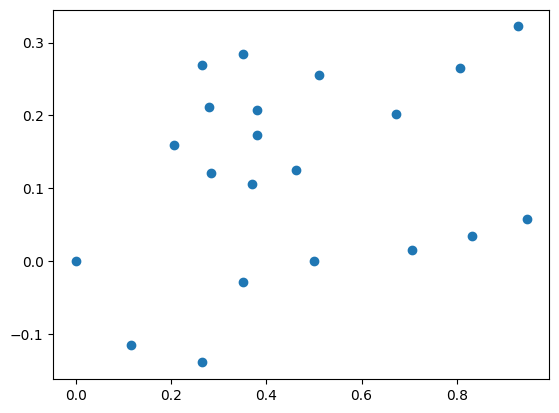

In [56]:
import matplotlib.pyplot as plt
x = []
y = []
for i in capturedLandmarks:
    x.append(i[0])
    y.append(i[1])

plt.scatter(x, y)
plt.show()